In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Author @Hitakshi Tripathi

Few shot learning technique without LSH sampleing method

this gives 59% accuracy when split in 90-10 split pattern i.e 4 images for training and rest for testing purpose

Kindly Note: (Requires 25GB of Google colab will crash for 12 GB)

In [2]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=0e00032f8738dc03a5cd43bc96e313d39370d42546a4ff83a55e4a242befa314
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [3]:
import os
import random
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

First, we'll load the images and their labels into two stratified train and test set numpy arrays. In order to accurately estimate the final generalizability of our model, we need to set aside the test set, and not look at it for the entire model analysis. 

In [4]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, stratify=y )

        
data = Dataset("/content/drive/MyDrive/Dataset", test_size=0.9, img_size=224)
print(data.X.shape,data.y.shape)


(120, 224, 224, 3) (120, 30)


 We will use Kolesnikov et al's BiT-M R101x1 model to compute our embeddings. 
It is a 101 layer ResNet (He et al. 2016) pretrained on the full ImageNet dataset.

Here 120 samples in Train (ie 4 each catogrey)
and remaining in test 

In [5]:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)


(120, 2048) (1085, 2048)


In [6]:
def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float
) -> tf.keras.Model:
    model = tf.keras.Sequential()
    #model = Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))
    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model


In [7]:
def evaluate_model(
    nclasses, X, y, X_dev, y_dev, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params
) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the dev set.
    model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, dev_acc = model.evaluate(X_dev, y_dev, batch_size=batch_size, verbose=0)
    return model, train_acc, dev_acc

With a dataset this small, we'll need to conduct repeated k-fold cross validation in order to get a real sense of the generalization performance of any given model

define a method for evaluating a model configuration using repeated k-fold cross validation

In [8]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, dev_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, dev_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_dev_fold = tf.gather(X, dev_index)
        y_dev_fold = tf.gather(y, dev_index)
        
        # Train and evaluate the model.
        _, train_acc, dev_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_dev_fold,
            y_dev_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        dev_accs.append(dev_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "dev_mean": np.mean(dev_accs),
        "dev_std": np.std(dev_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Dev", results["dev_mean"], results["dev_std"]]
                ],
                headers=["Set", "Mean", "Std. Dev."]
            )
        )
    
    return results

This is where we perform the actual cross validation of the model. We'll use 3 folds, repeated 4 times. Because the model is small, it will execute relatively quickly.

In [9]:
# We'll refer to these values throughout the notebook.
default_cv_evaluate_params = {
    "X": X_embedding,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 3,
    "nrepeats": 4,
    "model_maker": make_model,
    "epochs": 10,
    "batch_size": 16,
    "verbose": False,
    "learning_rate": 3e-3,
    "dropout_rate": 0.3,
    "nhiddenunits": 64,
    "l2_regularization": 1e-6
}

_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

Set        Mean    Std. Dev.
-----  --------  -----------
Train  0.197917    0.112249
Dev    0.114583    0.0766882


In [10]:
def search_hyperparam(
    param_name: str, lower: int, upper: int, nsamples: int,
    scale: str = "float", **cv_evaluate_params
) -> float:
    """
    Cross validates a model along an evenly spaced range of `nsamples`
    values for a single hyperparameter (identified by `param_name`. The
    values are evenly spaced in the range `[lower,upper]`, and scaled
    according to `scale`.
    """
    # Sample the hyperparameter values to try.
    param_values = np.linspace(lower, upper, nsamples)
    if scale == "log":
        param_values = 10**param_values
    elif scale == "int":
        param_values = param_values.astype(int)
    
    # Evaluate the model at each of the values.
    dev_means = np.zeros((nsamples, 1))
    dev_stds = np.zeros((nsamples, 1))
    for i in tqdm(range(nsamples)):
        results = cv_evaluate_model(
            **{
                **cv_evaluate_params,
                param_name: param_values[i]
            }
        )
        dev_means[i] = results["dev_mean"]
        dev_stds[i] = results["dev_std"]
    
    # Find the best value.
    best_param_value = param_values[np.argmax(dev_means)]
    print(f"Best {param_name} value: {best_param_value}")
    
    # Plot scores achieved for all values.
    plt.plot(param_values, dev_means)
    plt.xlabel(param_name)
    plt.ylabel("Mean Dev Set Accuracy")
    if scale == "log":
        plt.xscale("log")
    plt.show()
    
    return best_param_value

100%|██████████| 10/10 [05:22<00:00, 32.30s/it]

Best epochs value: 500


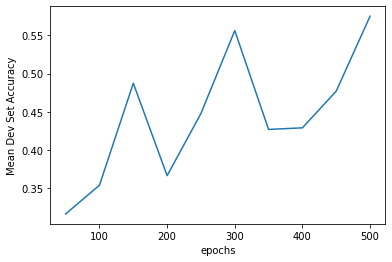

In [11]:
best_epochs = search_hyperparam("epochs", 50, 500, 10, scale="int", **default_cv_evaluate_params)

100%|██████████| 9/9 [08:59<00:00, 59.93s/it]

Best epochs value: 500


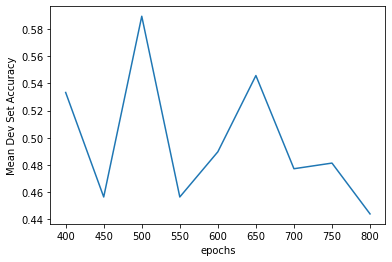

In [12]:
best_epochs2 = search_hyperparam("epochs", 400, 800, 9, scale="int", **default_cv_evaluate_params)

In [14]:
default_cv_evaluate_params["epochs"] = best_epochs2

In [15]:
def evaluate_final(params: dict) -> float:
    
    steps_per_epoch = math.ceil(len(X_embedding) / params["batch_size"])
    third_of_total_steps = math.floor(params["epochs"] * steps_per_epoch / 3)

    # Make and compile the model.
    model = make_model(
        data.nclasses,
        dropout_rate=params["dropout_rate"],
        nhiddenunits=params["nhiddenunits"],
        l2_regularization=params["l2_regularization"]
    )


    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                params["learning_rate"],
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train the model on the full training set (no development set)
    model.fit(
        X_embedding,
        tf.convert_to_tensor(data.y),
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        verbose=0
    )

    # Evaluate the fitted model on the test set.
    _, test_acc = model.evaluate(
        X_test_embedding,
        data.y_test,
        verbose=0
    )
    return test_acc
test_acc = evaluate_final(default_cv_evaluate_params)
print(f"Final test set accuracy:\t{test_acc:.6f}")

Final test set accuracy:	0.592627


In [16]:
import warnings
warnings.filterwarnings("ignore")

test_accs = []
for _ in tqdm(range(30)):
    test_accs.append(evaluate_final(default_cv_evaluate_params))

100%|██████████| 30/30 [03:36<00:00,  7.21s/it]


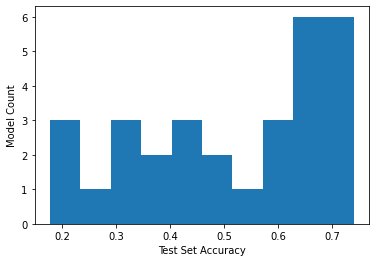

In [17]:
plt.hist(test_accs)
plt.xlabel("Test Set Accuracy")
plt.ylabel("Model Count")
plt.show()